# Generative AI Tools & Platforms 2025 — EDA + Baseline

Exploration + baseline modeling on the Generative AI Tools (2025) dataset.

**What’s inside**
- EDA: distributions, relationships, correlations.
- Models: Logistic Regression & RandomForest to predict open_source.
- Metrics: accuracy, macro-F1, confusion matrix.

Reproducible, Matplotlib-only, and pipeline-driven.

# Setup

In [1]:
import warnings; warnings.filterwarnings("ignore")

import os, json, glob
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, f1_score, classification_report, 
                             confusion_matrix, roc_auc_score)

SEED = 42
np.random.seed(SEED)

# Rendering defaults for Matplotlib
plt.rcParams["figure.figsize"] = (11, 6)
plt.rcParams["axes.grid"] = True

#  Load Data

In [2]:
df = pd.read_csv("/kaggle/input/generative-ai-tools-and-platforms-2025/Generative AI Tools - Platforms 2025.csv")

# Initial Audit

In [3]:
print("Shape:", df.shape)
print("\nDTypes:")
print(df.dtypes)

print("\nMissing values (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))


Shape: (113, 22)

DTypes:
tool_name              object
company                object
category_canonical     object
modality_canonical     object
open_source             int64
api_available           int64
api_status             object
website                object
source_domain          object
release_year            int64
years_since_release     int64
mod_text                int64
mod_image               int64
mod_video               int64
mod_audio               int64
mod_code                int64
mod_design              int64
mod_infra               int64
mod_productivity        int64
mod_safety              int64
mod_multimodal          int64
modality_count          int64
dtype: object

Missing values (top 20):
tool_name              0
company                0
mod_multimodal         0
mod_safety             0
mod_productivity       0
mod_infra              0
mod_design             0
mod_code               0
mod_audio              0
mod_video              0
mod_image              0

# Cleaning Data

In [4]:
df_clean = df.copy()

# Trim text
for c in df_clean.select_dtypes(include="object").columns:
    df_clean[c] = df_clean[c].astype(str).str.strip()

# Coerce booleans
for c in ["open_source","api_available"]:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce").fillna(0).astype(int)

# Numeric year
if "release_year" in df_clean.columns:
    df_clean["release_year"] = pd.to_numeric(df_clean["release_year"], errors="coerce")

# modality_count
if "modality_count" not in df_clean.columns:
    mod_flag_cols = [c for c in df_clean.columns if c.lower().startswith("mod_")]
    if len(mod_flag_cols):
        df_clean["modality_count"] = df_clean[mod_flag_cols].fillna(0).astype(int).sum(axis=1)
    elif "modality_canonical" in df_clean.columns:
        def count_modalities(s):
            if pd.isna(s): return 0
            tokens = [t.strip() for t in str(s).replace("|",",").replace(";",",").split(",") if t.strip()]
            return len(set(tokens))
        df_clean["modality_count"] = df_clean["modality_canonical"].apply(count_modalities)
    else:
        df_clean["modality_count"] = 0

# years_since_release
from datetime import datetime
if "release_year" in df_clean.columns:
    CURR_YEAR = datetime.now().year
    df_clean["years_since_release"] = (CURR_YEAR - df_clean["release_year"].fillna(CURR_YEAR)).astype(int)

print("Post-clean shape:", df_clean.shape)
df_clean.head()


Post-clean shape: (113, 22)


,tool_name,company,category_canonical,modality_canonical,open_source,api_available,api_status,website,source_domain,release_year,...,mod_image,mod_video,mod_audio,mod_code,mod_design,mod_infra,mod_productivity,mod_safety,mod_multimodal,modality_count
0,ChatGPT,OpenAI,LLMs & Chat Assistants,multimodal,0,1,api,https://chatgpt.com,chatgpt.com,2022,...,0,0,0,0,0,0,0,0,1,0
1,Claude,Anthropic,LLMs & Chat Assistants,multimodal,0,1,api,https://claude.ai,claude.ai,2023,...,0,0,0,0,0,0,0,0,1,0
2,Gemini,Google,LLMs & Chat Assistants,multimodal,0,1,api,https://gemini.google.com,gemini.google.com,2023,...,0,0,0,0,0,0,0,0,1,0
3,Midjourney,Midjourney,Image Gen & Editing,image,0,0,unavailable,https://www.midjourney.com,midjourney.com,2022,...,1,0,0,0,0,0,0,0,0,1
4,Stable Diffusion,Stability AI,Image Gen & Editing,image,1,1,api,https://stability.ai/stable-image,stability.ai,2022,...,1,0,0,0,0,0,0,0,0,1


# EDA — Distributions 

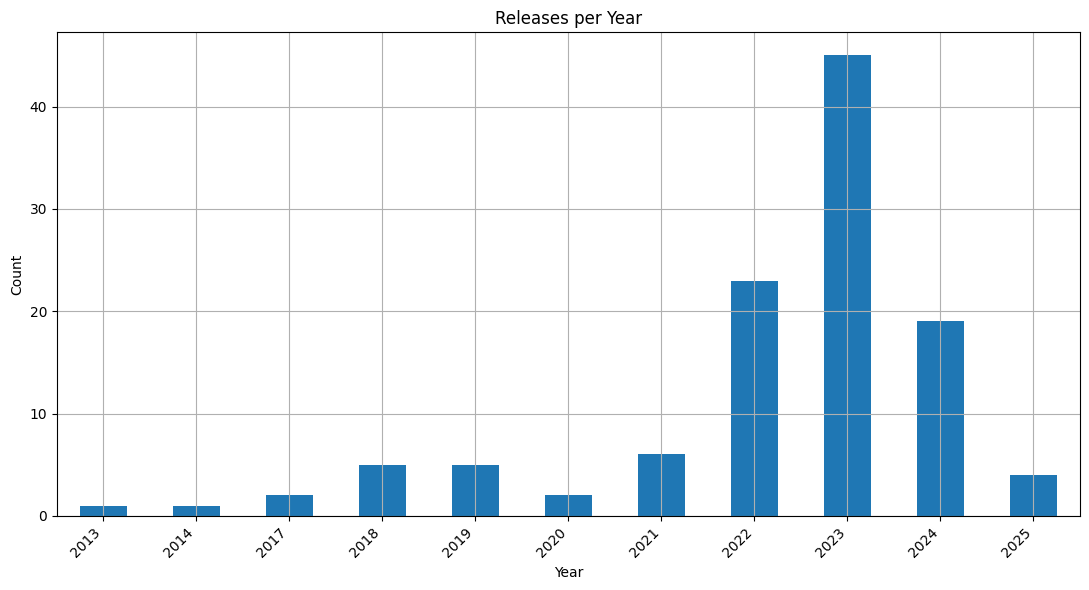

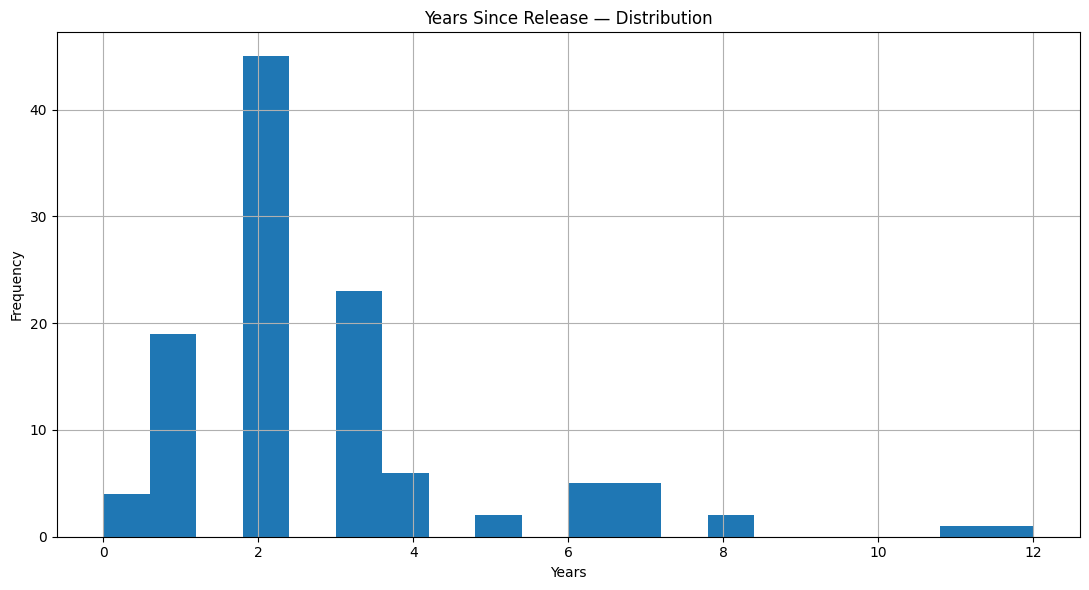

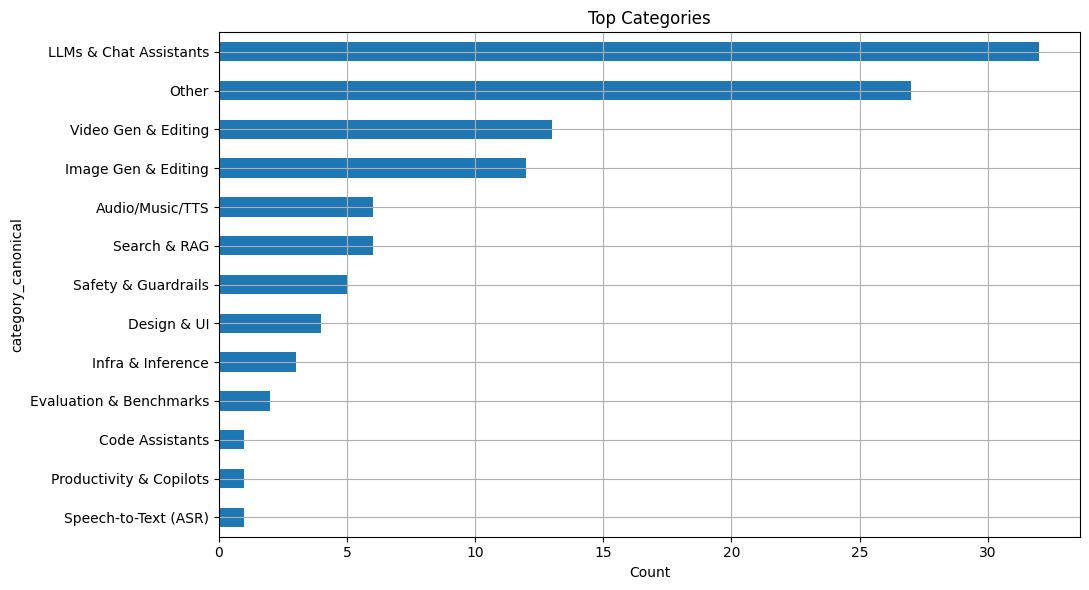

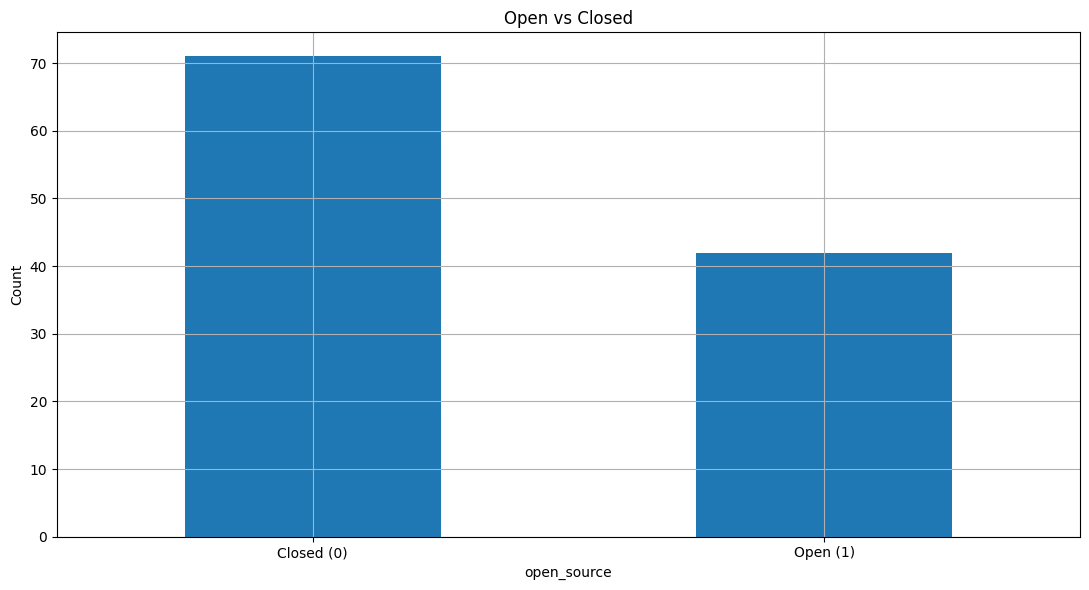

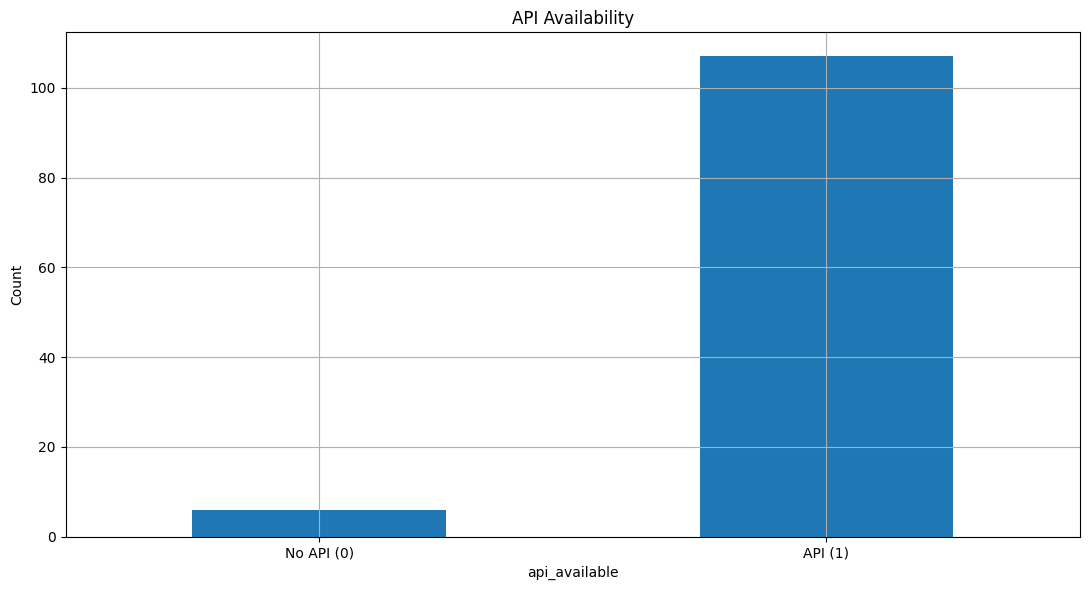

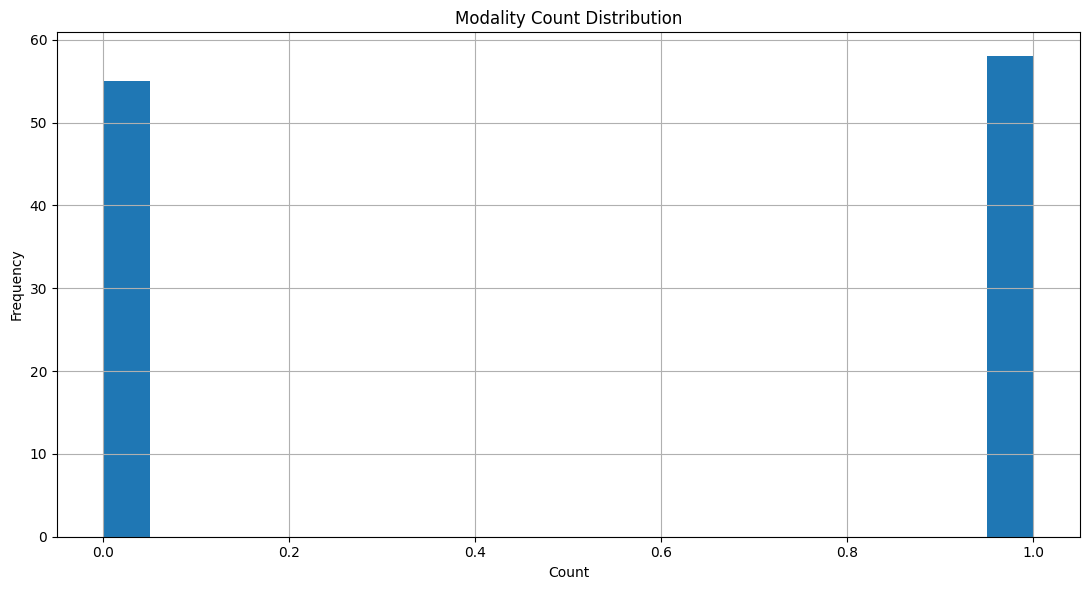

In [5]:

# Release Years (vertical bars, rotated ticks)
if "release_year" in df_clean.columns:
    yr = df_clean["release_year"].value_counts().sort_index()
    ax = yr.plot(kind="bar", title="Releases per Year")
    ax.set_xlabel("Year"); ax.set_ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout(); plt.show()

# Years since release
if "years_since_release" in df_clean.columns:
    ax = df_clean["years_since_release"].plot(kind="hist", bins=20, title="Years Since Release — Distribution")
    ax.set_xlabel("Years"); plt.tight_layout(); plt.show()
    
# Top Categories (barh, largest on top)
if "category_canonical" in df_clean.columns:
    counts = df_clean["category_canonical"].value_counts().head(15).sort_values(ascending=False)
    ax = counts.plot(kind="barh", title="Top Categories")
    ax.invert_yaxis()
    ax.set_xlabel("Count"); ax.set_ylabel("category_canonical")
    plt.tight_layout(); plt.show()

# Open Source split (vertical bars, custom labels)
if "open_source" in df_clean.columns:
    vals = df_clean["open_source"].value_counts().reindex([0,1]).fillna(0).astype(int)
    ax = vals.plot(kind="bar", title="Open vs Closed")
    ax.set_xticklabels(["Closed (0)","Open (1)"], rotation=0)
    ax.set_ylabel("Count")
    plt.tight_layout(); plt.show()

# API availability (vertical bars, custom labels)
if "api_available" in df_clean.columns:
    vals = df_clean["api_available"].value_counts().reindex([0,1]).fillna(0).astype(int)
    ax = vals.plot(kind="bar", title="API Availability")
    ax.set_xticklabels(["No API (0)","API (1)"], rotation=0)
    ax.set_ylabel("Count")
    plt.tight_layout(); plt.show()

# Modality count (hist)
if "modality_count" in df_clean.columns:
    ax = df_clean["modality_count"].plot(kind="hist", bins=20, title="Modality Count Distribution")
    ax.set_xlabel("Count")
    plt.tight_layout(); plt.show()


# EDA — Relationships

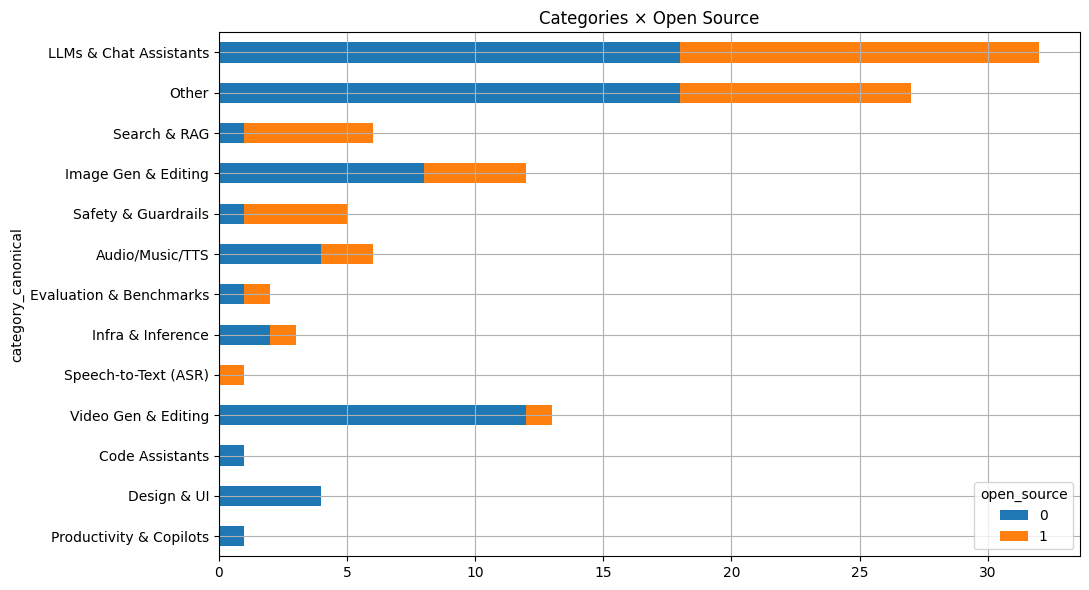

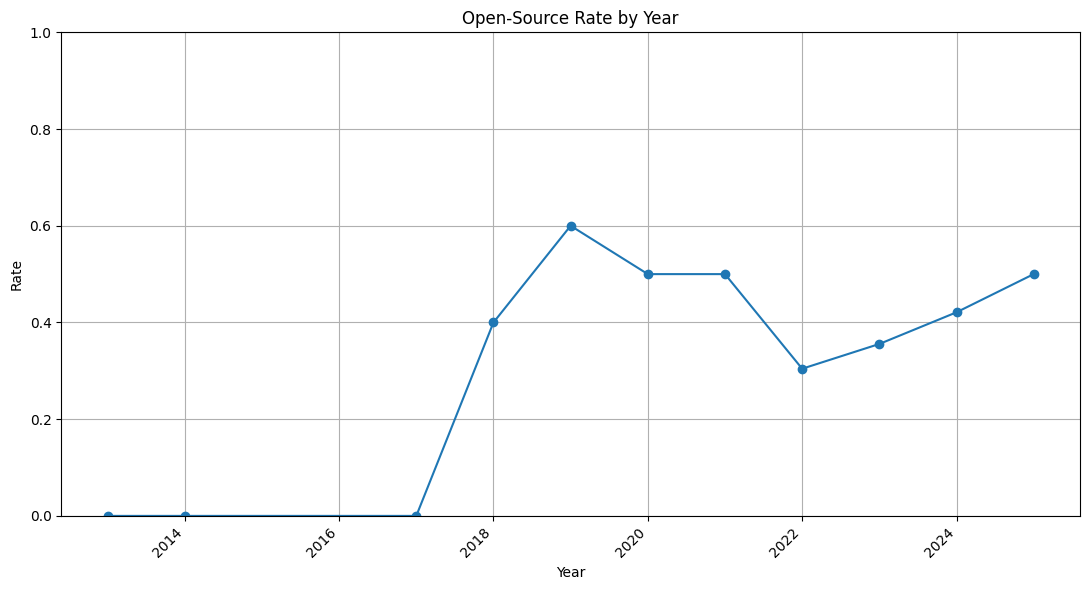

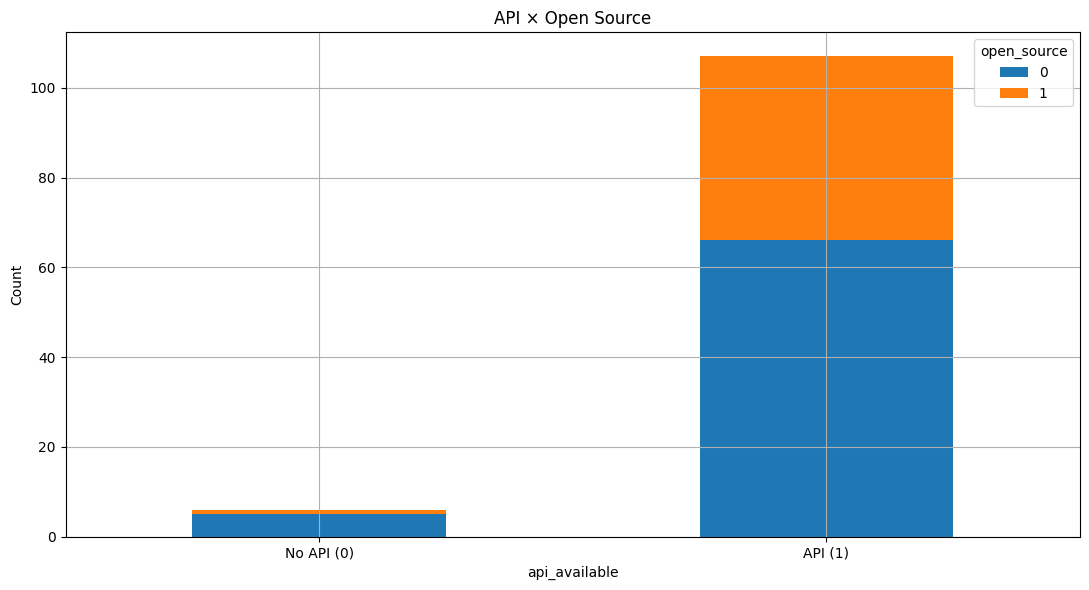

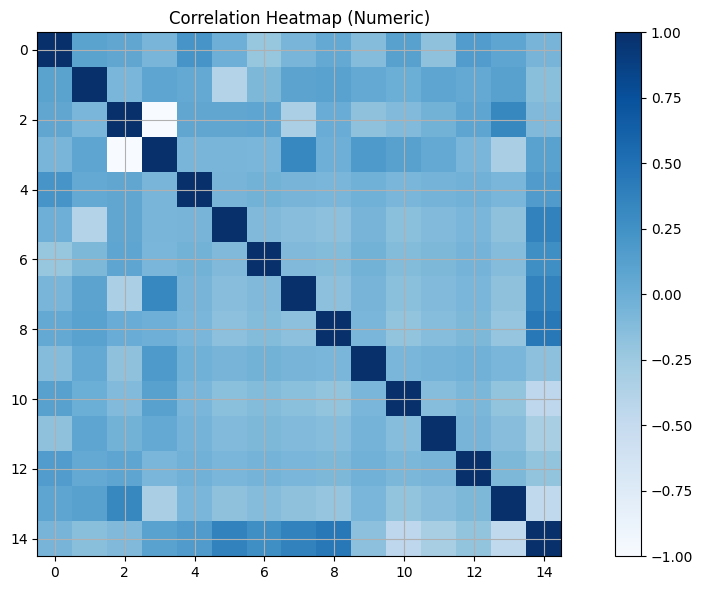

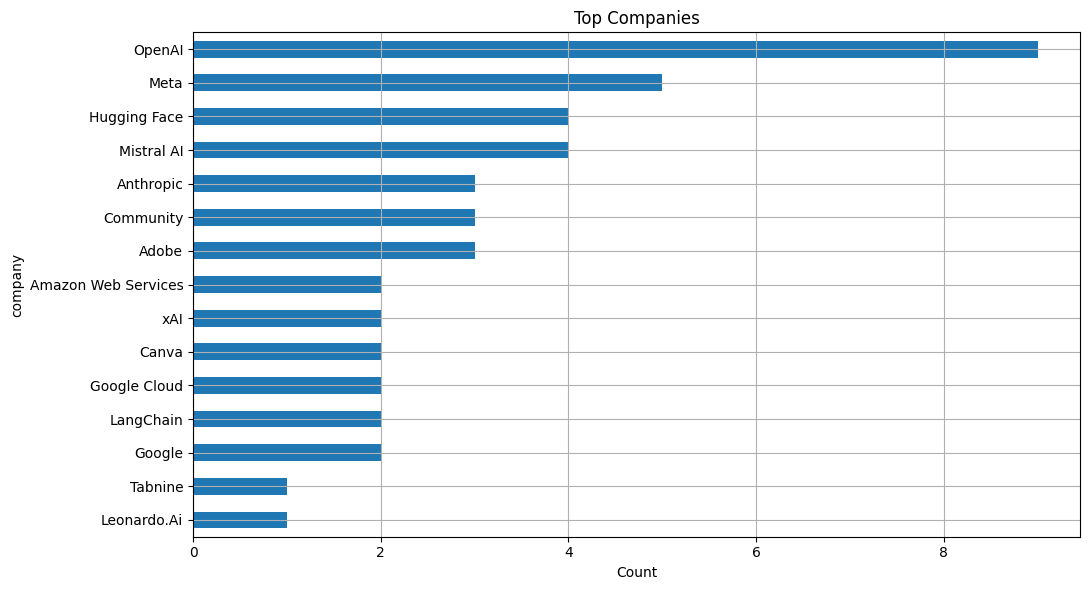

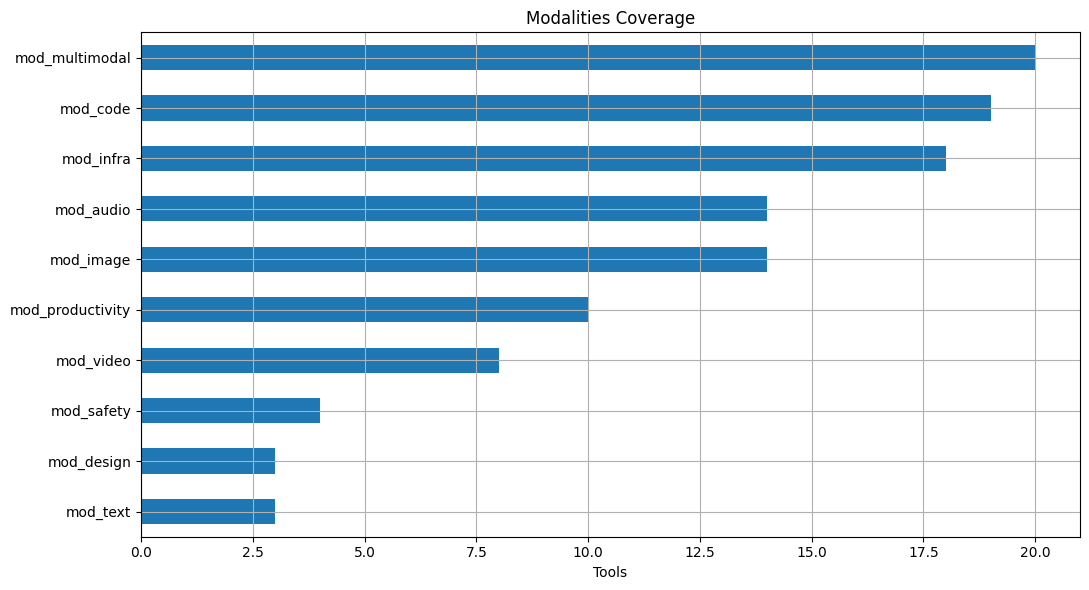

In [6]:

# Category × Open Source (barh stacked, largest on top)
if {"category_canonical","open_source"}.issubset(df_clean.columns):
    ctab = pd.crosstab(df_clean["category_canonical"], df_clean["open_source"])
    # sort by '1' column if exists else last column
    sort_col = 1 if 1 in ctab.columns else ctab.columns[-1]
    ctab = ctab.sort_values(by=sort_col, ascending=False).head(15)
    ax = ctab.plot(kind="barh", stacked=True, title="Categories × Open Source")
    ax.invert_yaxis()
    plt.tight_layout(); plt.show()

# Open-Source Rate by Year (rotate ticks)
if {"release_year","open_source"}.issubset(df_clean.columns):
    rate = df_clean.groupby("release_year")["open_source"].mean().sort_index()
    ax = rate.plot(marker="o", title="Open-Source Rate by Year")
    ax.set_ylim(0,1); ax.set_xlabel("Year"); ax.set_ylabel("Rate")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout(); plt.show()

# API × Open Source (vertical stacked bars with labels)
if {"api_available","open_source"}.issubset(df_clean.columns):
    ctab = pd.crosstab(df_clean["api_available"], df_clean["open_source"]).reindex([0,1], fill_value=0)
    ax = ctab.plot(kind="bar", stacked=True, title="API × Open Source")
    ax.set_xticklabels(["No API (0)","API (1)"], rotation=0)
    ax.set_ylabel("Count")
    plt.tight_layout(); plt.show()

# Correlation Heatmap (numeric)
num_df = df_clean.select_dtypes(include=[np.number])
if num_df.shape[1] >= 2:
    plt.imshow(num_df.corr(), cmap="Blues")
    plt.title("Correlation Heatmap (Numeric)"); plt.colorbar(); plt.tight_layout(); plt.show()

# Top Companies (barh, largest on top)
if "company" in df_clean.columns:
    counts = df_clean["company"].value_counts().head(15).sort_values(ascending=False)
    ax = counts.plot(kind="barh", title="Top Companies")
    ax.invert_yaxis()
    ax.set_xlabel("Count"); ax.set_ylabel("company")
    plt.tight_layout(); plt.show()

# Modalities coverage from mod_* flags (barh, natural order ok)
mod_cols = [c for c in df_clean.columns if c.lower().startswith("mod_")]
if len(mod_cols):
    counts = df_clean[mod_cols].fillna(0).astype(int).sum().sort_values()
    ax = counts.plot(kind="barh", title="Modalities Coverage")
    ax.set_xlabel("Tools")
    plt.tight_layout(); plt.show()


# Class Balance

Class balance: {0: 0.628, 1: 0.372}


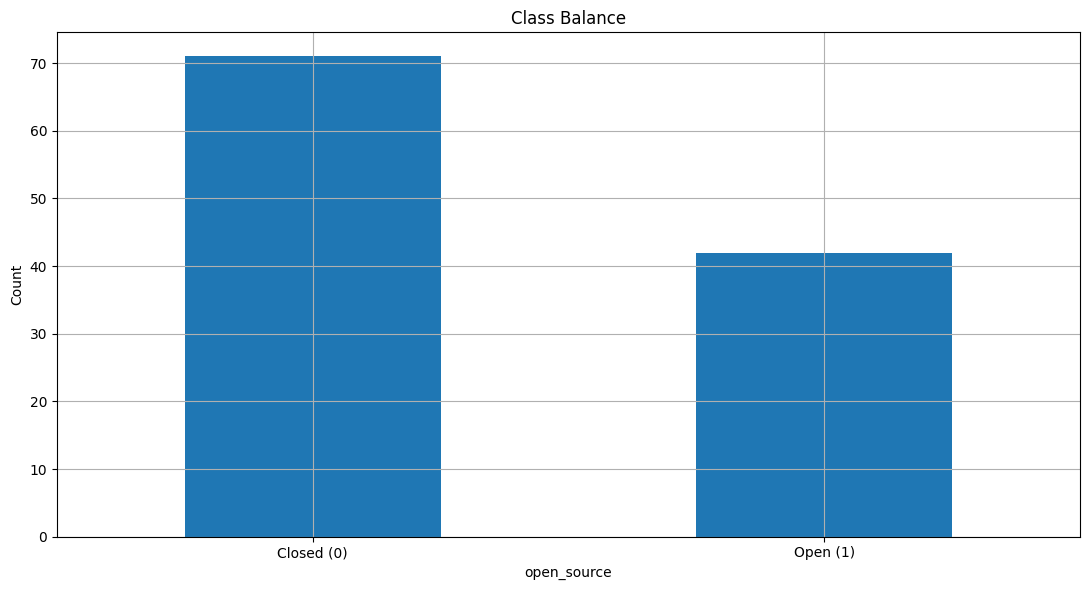

In [7]:
target = "open_source"
assert target in df_clean.columns, f"Target '{target}' not found."

y = df_clean[target].astype(int)
print("Class balance:", y.value_counts(normalize=True).round(3).to_dict())

vals = y.value_counts().reindex([0,1]).fillna(0).astype(int)
ax = vals.plot(kind="bar", title="Class Balance")
ax.set_xticklabels(["Closed (0)","Open (1)"], rotation=0)
ax.set_ylabel("Count"); plt.tight_layout(); plt.show()


# Baseline Modeling

In [8]:

# Features
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if target in numeric_cols:
    numeric_cols.remove(target)

# Drop constant numeric features
constant_numeric = [c for c in numeric_cols if df_clean[c].nunique(dropna=True) <= 1]
numeric_cols = [c for c in numeric_cols if c not in constant_numeric]
if constant_numeric:
    print("Dropping constant numeric cols:", constant_numeric)

candidate_cat = ["tool_name", "company", "category_canonical", "modality_canonical", 
                 "api_status", "website", "source_domain"]
categorical_cols = [c for c in candidate_cat if c in df_clean.columns]

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

X = df_clean[categorical_cols + numeric_cols].copy()
y = df_clean[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Preprocess: OHE for categoricals, median-impute numeric, most_frequent for categoricals
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # older sklearn

num_pipe = Pipeline([("impute", SimpleImputer(strategy="median"))])
cat_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                     ("ohe", ohe)])

preprocess = ColumnTransformer([
    ("cat", cat_pipe, categorical_cols),
    ("num", num_pipe, numeric_cols),
])

models = {
    "logreg": Pipeline([("prep", preprocess),
                        ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=SEED))]),
    "random_forest": Pipeline([("prep", preprocess),
                               ("clf", RandomForestClassifier(n_estimators=400, class_weight="balanced",
                                                              random_state=SEED, n_jobs=-1))]),
    "grad_boost": Pipeline([("prep", preprocess),
                            ("clf", GradientBoostingClassifier(random_state=SEED))]),
}

results = {}
proba_cache = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results[name] = {
        "accuracy": accuracy_score(y_test, pred),
        "macro_f1": f1_score(y_test, pred, average="macro", zero_division=0),
    }
    # Try to compute ROC-AUC if predict_proba is available
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:,1]
        proba_cache[name] = proba
        try:
            results[name]["roc_auc"] = roc_auc_score(y_test, proba)
        except Exception:
            results[name]["roc_auc"] = np.nan

pd.DataFrame(results).T.sort_values("macro_f1", ascending=False)


Numeric: ['api_available', 'release_year', 'years_since_release', 'mod_text', 'mod_image', 'mod_video', 'mod_audio', 'mod_code', 'mod_design', 'mod_infra', 'mod_productivity', 'mod_safety', 'mod_multimodal', 'modality_count']
Categorical: ['tool_name', 'company', 'category_canonical', 'modality_canonical', 'api_status', 'website', 'source_domain']


,accuracy,macro_f1,roc_auc
logreg,0.608696,0.596491,0.662698
random_forest,0.608696,0.462338,0.666667
grad_boost,0.608696,0.462338,0.634921


### Metrics + Confusion Matrix (best model)

Best model: logreg
Accuracy: 0.6086956521739131
Macro-F1: 0.5964912280701754
ROC-AUC: 0.6626984126984127

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.64      0.67        14
           1       0.50      0.56      0.53         9

    accuracy                           0.61        23
   macro avg       0.60      0.60      0.60        23
weighted avg       0.62      0.61      0.61        23



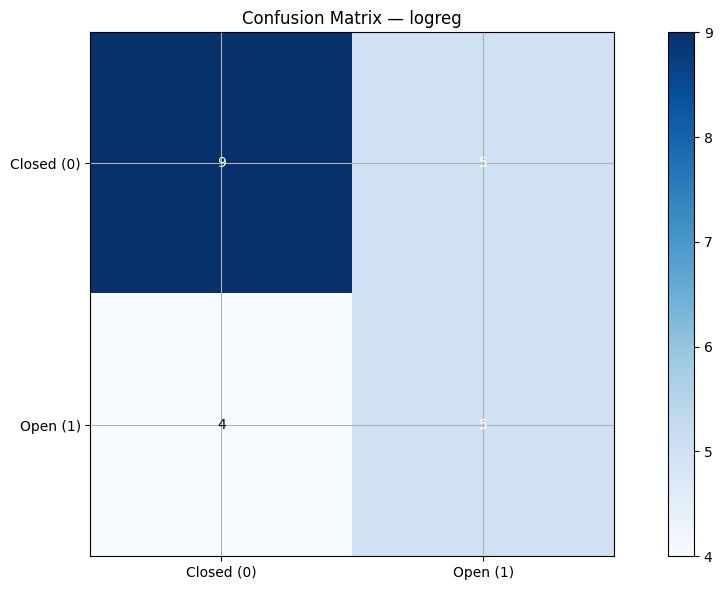

In [9]:

res_df = pd.DataFrame(results).T
best_name = res_df["macro_f1"].astype(float).idxmax()
best_model = models[best_name]

y_pred = best_model.predict(X_test)
print("Best model:", best_name)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro", zero_division=0))
if best_name in proba_cache:
    try:
        print("ROC-AUC:", roc_auc_score(y_test, proba_cache[best_name]))
    except Exception:
        pass
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
plt.imshow(cm, cmap="Blues")
plt.title(f"Confusion Matrix — {best_name}")
plt.colorbar()
plt.xticks([0,1], ["Closed (0)","Open (1)"])
plt.yticks([0,1], ["Closed (0)","Open (1)"])
th = cm.max()/2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center", color=("white" if cm[i,j] > th else "black"))
plt.tight_layout(); plt.show()


## Appendix — Data Dictionary 

- `tool_name` — product / project name  
- `company` — publisher / developer  
- `category_canonical` — taxonomy label  
- `modality_canonical` — delimited modalities (e.g., `Text|Image|Video`)  
- `open_source` — 0/1  
- `api_available` — 0/1  
- `release_year` — first public release year  
- `years_since_release` — derived (current year − release_year)  
- `mod_*` — modality flags (0/1) per capability  
- `modality_count` — total modalities inferred from flags or parsed list